In [1]:
label_dict = {'other_relevant_information': 1, 'affected_individuals': 2, 'infrastructure_and_utility_damage': 3, 'injured_or_dead_people': 4, 
                               'rescue_volunteering_or_donation_effort': 5, 'not_humanitarian': 0}

In [2]:
tuple(label_dict.keys())

('other_relevant_information',
 'affected_individuals',
 'infrastructure_and_utility_damage',
 'injured_or_dead_people',
 'rescue_volunteering_or_donation_effort',
 'not_humanitarian')

In [1]:
from pathlib import Path
import os
import pandas as pd

# access the data from the folders
home = Path(os.path.expanduser('~'))
dir = home / 'CrisisMMD_v2.0' / 'CrisisMMD_v2.0' 
data_dir = dir / 'crisismmd_datasplit_all' / 'crisismmd_datasplit_all'
train_data = pd.read_csv(data_dir / 'task_humanitarian_text_img_train.tsv', sep='\t')

In [2]:
data_labels = train_data['label_image'].value_counts().reset_index()['label_image'].to_dict()


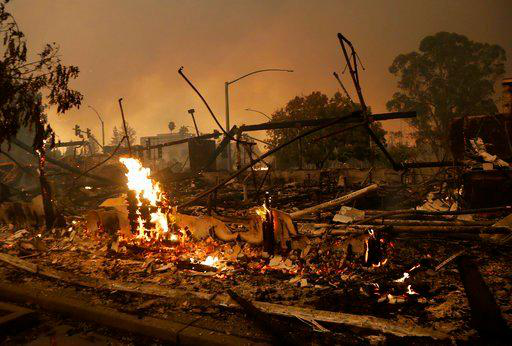

In [3]:
from PIL import Image

Image.open(dir / train_data.iloc[2]['image'])

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from torch.utils.data import Dataset

class SQLDataset_Humanitarian(Dataset):
    '''
    Parameters: 
    - dir: The directory where the folder containing the images is located
    - file_path: The path to the TSV file containing the image paths and labels
    - transform: Optional transform to be applied on a sample (e.g., for data augmentation)
    '''
    def __init__(self, dir, file_path, transform=None):
        self.dir = Path(dir)
        self.file_path = file_path
        self.data = pd.read_csv(file_path, sep='\t')
        self.image_paths = self.data['image'].tolist()
        self.labels = self.data['label_image']
        self.label_dict = {value: key for key, value in 
                           self.data['label_image'].value_counts().reset_index()['label_image'].to_dict().items()}
        self.transform = transform
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        '''
        Returns a tuple of (image, label) for the given index.
        The image is loaded as a PIL Image, and the label is converted to an integer using the label_dict.
        If a transform was provided, it is applied to the image.
        '''
        img = Image.open(self.dir / self.image_paths[idx])
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        
        label = self.label_dict[label] # convert label to int
        return img, label



In [5]:
trainset = SQLDataset_Humanitarian(dir, data_dir / 'task_humanitarian_text_img_train.tsv')

In [6]:
import numpy as np
trainset_arr0 = np.array([np.array(trainset.__getitem__(i)[0].convert('RGB').resize((224, 224))) for i in range(len(trainset)) if trainset.__getitem__(i)[1] == 0])
trainset_arr2 = np.array([np.array(trainset.__getitem__(i)[0].convert('RGB').resize((224, 224))) for i in range(len(trainset)) if trainset.__getitem__(i)[1] == 2])

c:\Users\bowdenaa\AppData\Local\anaconda3\envs\torch\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [30]:
pos_pairs = []
neg_pairs = []
# Iterate through all pairs of images of the same class 
for img0 in trainset_arr0:
    for img01 in trainset_arr0:
        if not np.array_equal(img0, img01):
            pos_pairs.append((img0, img01))

for img2 in trainset_arr2:
    for img21 in trainset_arr2:
        if not np.array_equal(img2, img21):
            pos_pairs.append((img2, img21))

# Iterate through all pairs of images of different classes
for img0 in trainset_arr0:
    for img2 in trainset_arr2:
        neg_pairs.append((img0, img2))


KeyboardInterrupt: 

In [7]:
from data_helper import contrastive_loss, best_transformation
import cv2
import skimage

transforms = [cv2.HuMoments, skimage.feature.graycomatrix, cv2.calcHist, skimage.feature.local_binary_pattern]
my_dict = best_transformation(transforms, trainset_arr0, trainset_arr2)



100%|██████████| 15/15 [08:41<00:00, 34.77s/it]


In [8]:
my_dict 

{(<function HuMoments>,
  <function skimage.feature.texture.graycomatrix(image, distances, angles, levels=None, symmetric=False, normed=False)>,
  <function calcHist>,
  <function skimage.feature.texture.local_binary_pattern(image, P, R, method='default')>): {'inter-score': 1565.5759910448635,
  'intra-score class 1': 1572.9189693978683,
  'intra-score class 2': 1507.868074161647},
 (<function HuMoments>,
  <function skimage.feature.texture.graycomatrix(image, distances, angles, levels=None, symmetric=False, normed=False)>,
  <function calcHist>): {'inter-score': 463.5129202557474,
  'intra-score class 1': 455.7162481277138,
  'intra-score class 2': 454.79786718322805},
 (<function HuMoments>,
  <function skimage.feature.texture.graycomatrix(image, distances, angles, levels=None, symmetric=False, normed=False)>,
  <function skimage.feature.texture.local_binary_pattern(image, P, R, method='default')>): {'inter-score': 1468.5014214739053,
  'intra-score class 1': 1477.751628620093,
  'in